In [228]:
import numpy as np
import os
from collections import Counter

In [229]:
def get_texts(filename, split=True, pad = True, pad_n = 20, update_file = False, skip_len = 3):
    if not os.path.exists(f'./dataset/padded_{filename}') or not update_file:
        
        with(open(f'./dataset/{filename}', 'r', encoding='utf-8')) as texts_file:
            texts = texts_file.read().split('\n')
        
        texts_to_save = []
        result = []

        for text in texts:
            if split:
                text = text.split()
            
            if pad and len(text) >= skip_len:
            
                if len(text) > pad_n:
                    text = text[0:pad_n]
                elif len(text) != pad_n:
                    text = list(pad_sequence(text, pad_n - len(text) + 1, pad_right=True, right_pad_symbol='<PAD>'))
            
            if split:
                texts_to_save.append(' '.join(text) + '\n')
            else:
                texts_to_save.append(text + '\n')
                
            result.append(text)
        
        with(open(f'./dataset/padded_{filename}', '+w', encoding='utf-8')) as texts_file:
            texts_file.writelines(texts_to_save) 
    else:
        with(open(f'./dataset/padded_{filename}', 'r', encoding='utf-8')) as texts_file:
            texts = texts_file.read().split('\n')
            result = [text.split() if split else text for text in texts]
    return result

In [247]:
corpus = get_texts('bmstu_vk.txt', pad=False)
corpus = corpus[7000:25000]

In [231]:
def create_corpus_dict(corpus):
    words = [word for text in corpus for word in text]
    words = [word for word in Counter(words).most_common()]
    words_corpus = sorted(words, key=lambda w: w[1], reverse=True)
    words_corpus = [(word[0], index) for index, word in enumerate(words_corpus)]
    return dict(words_corpus)

In [248]:
corpus_dict = create_corpus_dict(corpus)
len(corpus_dict)

22840

In [233]:
def create_emb_matrix(vec_size, dict_size):
    return np.random.normal(size=(dict_size, vec_size))

In [234]:
def get_word_position(word, corpus_dict):
    word_position = corpus_dict[word]
    return word_position

In [235]:
def create_one_hot(word_pos, dict_size):
    vec = np.zeros(shape=(dict_size,1))
    vec[word_pos] = 1
    return vec

In [236]:
def get_word_emb(word, corpus_dict, emb_matrix):
    word_position = corpus_dict[word]
    return emb_matrix[word_position]

In [237]:
def create_weight_matrix(vec_size, dict_size):
    return create_emb_matrix(dict_size, vec_size)

In [238]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [239]:
def predict(word_vec, weights):
    embs, weight = weights
    hidden = np.dot(embs.T, word_vec)
    out = np.dot(weight.T, hidden)
    return softmax(out), out, hidden

In [240]:
def create_train_dataset(corpus, window_size, corpus_dict):
    dataset = []
    for sentence in corpus:
      
        sent_len = len(sentence)
      
        for i, word in enumerate(sentence):
      
            word_vec = get_word_position(word, corpus_dict)
            context = []
      
            for j in range(i - window_size, i + window_size):
                
                if j >= 0 and j < sent_len and j != i:
                    context_word_vector = get_word_position(sentence[j], corpus_dict)
                    context.append(context_word_vector)
      
            dataset.append((word_vec, context))
    return dataset


In [241]:
def backprop(error, hidden, word, weights):
    lr = 0.01
    embs, hidden_w = weights
    dl_dw2 = np.outer(hidden, error)
    dl_dw1 = np.outer(word, np.dot(hidden_w, error))
    embs = embs - (lr * dl_dw1)
    hidden_w = hidden_w - (lr * dl_dw2)
    return (embs, hidden_w)

In [249]:
from tqdm import tqdm

def train(corpus, corpus_dict, window=2, vec_size=3, epochs = 7):
    train_dataset = create_train_dataset(corpus, window, corpus_dict)

    dict_size = len(corpus_dict)

    weights = (create_emb_matrix(vec_size, dict_size), create_weight_matrix(vec_size, dict_size))

    for epoch in range(epochs):

        loss = 0

        with tqdm(total=len(train_dataset), file=sys.stdout) as bar:
            for word, context in train_dataset:

                word_vec = create_one_hot(word, dict_size)
                
                context_vecs = [ create_one_hot(word, dict_size) for word in context ]

                y_hat, out, hidden = predict(word_vec, weights)

                if context_vecs != []:
                    error = np.sum([np.subtract(y_hat, word) for word in context_vecs], axis=0)
                else:
                    error = np.zeros(shape=(dict_size, 1))
            
                weights = backprop(error, hidden, word_vec, weights)

                loss += -np.sum([out[np.where(word == 1)] for word in context_vecs]) + len(context_vecs) * np.log(np.sum(np.exp(out)))
            
                bar.update(1)

        print(f'Epoch: {epoch}, Loss: {loss}')
    return weights[0]

In [250]:
embs_matrix = train(corpus, corpus_dict)

100%|██████████| 296303/296303 [23:39<00:00, 208.69it/s]
Epoch: 0, Loss: 8007216.113356436
100%|██████████| 296303/296303 [20:48<00:00, 237.35it/s]
Epoch: 1, Loss: 7030350.192248604
100%|██████████| 296303/296303 [21:40<00:00, 227.90it/s]
Epoch: 2, Loss: 6749807.973260947
100%|██████████| 296303/296303 [22:58<00:00, 214.96it/s]
Epoch: 3, Loss: 6620220.8098168885
100%|██████████| 296303/296303 [19:37<00:00, 251.64it/s]
Epoch: 4, Loss: 6541819.114205915
100%|██████████| 296303/296303 [21:40<00:00, 227.77it/s]
Epoch: 5, Loss: 6488220.039056227
100%|██████████| 296303/296303 [25:30<00:00, 193.64it/s]
Epoch: 6, Loss: 6448576.371402015


In [281]:
top_words = [word for word in corpus_dict][:100]
top_words_embs = [get_word_emb(word, corpus_dict, embs_matrix) for word in top_words]

In [282]:
from sklearn.manifold import TSNE

top_words_embs_pca = TSNE(2).fit_transform(top_words_embs)

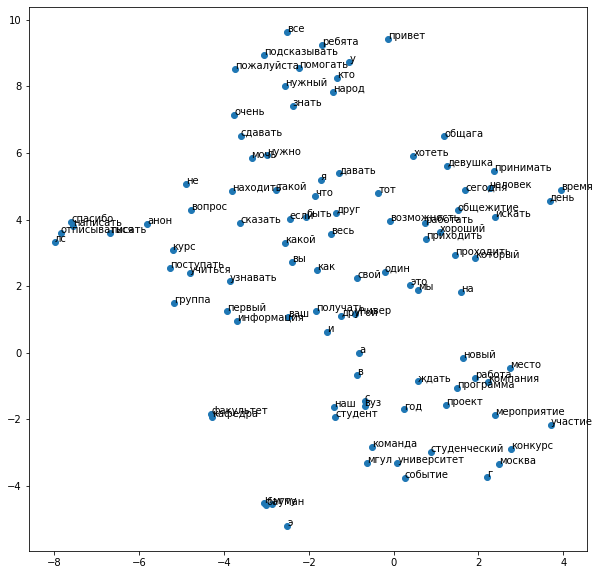

In [283]:
import matplotlib.pyplot as plt 

fix, ax = plt.subplots(figsize=(10,10))

x,y = top_words_embs_pca[:, 0], top_words_embs_pca[:, 1]

plt.scatter(x,y)

for i, word in enumerate(top_words):
    ax.annotate(word, (x[i], y[i]))

In [274]:
len(corpus_dict)

22840